In [1]:
!pip install pandas numpy ipywidgets

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
FOLDER_TO_SAVE = '/home/cin/Documents/tese/overleaf_project/latex_files/figs/tlfw/'

In [3]:
import matplotlib.pyplot as plt

#plt.style.use('ggplot')
plt.rc('axes', axisbelow=True)

In [34]:
from collections import defaultdict
import pandas as pd
import numpy as np
from scipy.linalg import eig
from scipy.stats import binom
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

# Formulas


$$
\begin{aligned}
     R_{kl} &= \sum_{j=0}^{n} S_{kj} M_{jl}= \begin{cases}
     \displaystyle\sum_{j=0}^{n} \bar{w}_k \mathrm{Pr}\left(\mathrm{Bin}\left( n, \dfrac{kw_k^A}{n\bar{w}_k} \right) = j \right)
           \left[\mathrm{Pr}(\mathrm{Bin}(j,1-m)=l) + mj \right], & \mbox{if $l=1$} \\
     \displaystyle\sum_{j=0}^{n} \bar{w}_k \mathrm{Pr}\left(\mathrm{Bin}\left( n, \dfrac{kw_k^A}{n\bar{w}_k} \right) = j\right)
     \mathrm{Pr}(\mathrm{Bin}(j,1-m)=l),  & \mbox{if $l \neq 1$} 
     \end{cases}
\end{aligned}
$$

And $w_k$ is defined by:
$$
w_k = \frac{k w_k^A + (n-k) w_k^N}{n} \,,
$$in which: $w_k^* = 1 + \delta v_k^*$, for any $^* \in \{A, N\}$, with selection strength given by $0 \geq \delta \geq 1$ and payoff function $v_k$, dependent on the number of individuals with trait $A$ inside a group, $k$.

In [85]:
class SelectionMatrix():
    selmatrix  = {}
    def __init__(self, v_k, args):
        self.fn_fun = fn_fun(v_k)
        self.args = args
        self.n = args[0]
        self.avg_fitness_func = self.avg_fitness()
        self.ref_fitness = self.init_ref_fitness()
        self.ref_avg_fitness = self.init_ref_avg_fitness()
        self.ref_probs_reproduc = self.init_ref_probs_reproduc()
        self.ref_selection_matrix = self.init_ref_selection_matrix()
    
    @staticmethod
    def make(v_k, args):
        if (v_k, args) not in SelectionMatrix.selmatrix:
            SelectionMatrix.selmatrix[(v_k, args)] = SelectionMatrix(v_k, args)
        return SelectionMatrix.selmatrix[(v_k, args)]
    
    def avg_fitness(self):
        def _avg_fitness(k):
            return (k*self.fn_fun(1, k, *self.args) + (self.n-k)*self.fn_fun(0, k, *self.args))/n
        return _avg_fitness
        
    def init_ref_fitness(self):
        return np.array([self.fn_fun(1, k, *self.args) for k in range(self.n+1)])
    
    def init_ref_avg_fitness(self):
        return np.array([self.avg_fitness_func(k) for k in range(self.n+1)])
    
    def init_ref_probs_reproduc(self):
        k_values = np.arange(n+1)
        wkA_div_avg_wk = np.divide(self.ref_fitness, self.ref_avg_fitness,
                                   out=np.zeros_like(self.ref_fitness), where=self.ref_avg_fitness!=0)
        ref_probs = (k_values/self.n)*wkA_div_avg_wk
        return np.maximum(np.minimum(ref_probs, np.ones(self.n+1)), np.zeros(n+1))
    
    def init_ref_selection_matrix(self):
        """Returns matrix in which row is k and column is j
        """
        reproduc_matrix = np.array([binom.pmf(np.arange(self.n+1), self.n, p) for p in self.ref_probs_reproduc])
        return self.ref_avg_fitness.reshape((self.n+1, 1))*reproduc_matrix

In [86]:
class MatrixCalculator():
    def __init__(self, v_k, m, args):
        self.sel_matrix_obj =  SelectionMatrix.make(v_k, args)
        self.fn_fun = self.sel_matrix_obj.fn_fun
        self.m = m
        self.args = args
        self.n = self.sel_matrix_obj.n
        self.ref_selection_matrix = self.sel_matrix_obj.ref_selection_matrix
        self.ref_migration_matrix = self.init_ref_migration_matrix()
        self.rho = None
        self.nu = None
    
    def init_ref_migration_matrix(self):
        """Returns matrix in which row is j and column is l
        """
        main_matrix = np.array([binom.pmf(np.arange(n+1), j, 1-self.m) for j in range(self.n+1)])
        mask_matrix = np.zeros(main_matrix.shape)
        mask_matrix[:,1] = self.m*np.arange(n+1)
        return main_matrix + mask_matrix
    
    def calc_matrix_r(self):
        return np.matmul(self.ref_selection_matrix, self.ref_migration_matrix)[1:, 1:]
    
    def calc_dominant_eigenval_eigenvec(self):
        matrix_r = self.calc_matrix_r()
        eigenvals, eigenvecs = eig(matrix_r, left=True, right=False)
        max_idx = np.argmax(eigenvals)
        self.rho = eigenvals[max_idx]
        self.nu = eigenvecs[:, max_idx]/np.sum(eigenvecs[:, max_idx])

    def calc_rho(self):
        if self.rho is None:
            self.calc_dominant_eigenval_eigenvec()
        return self.rho
    
    def calc_nu(self):
        if self.nu is None:
            self.calc_dominant_eigenval_eigenvec()
        return self.nu        

## Payoff functions

### Public goods game:
$$
v^A_k = -C + (k-1)B/(n-1),  \\
v^N_k =    k B/(n-1),
$$

### Iterated public goods game:
$$
\begin{align}
v^A_k & = \left\{
                \begin{array}{cc}
                                    -C + \dfrac{(k-1)B}{n-1},  & \mbox{if  $k \leq \theta$},  \\
                                   T \, \left(-C + \dfrac{(k-1)B}{n-1}\right), & \mbox{if  $k > \theta$}, 
                \end{array}
\right.  \\
v^N_k & =  \left\{
                \begin{array}{cc} 
                                    \dfrac{kB}{n-1},  & \mbox{if  $k \leq \theta$},  \\
                                    T \, \dfrac{kB}{n-1}, & \mbox{if  $k > \theta$},  
                \end{array}
\right.
\end{align}
$$
for $0 < C < B$, $T \geq 1$ and $\theta \in \{1,2,...,n-1\}$

### Threshold model:
$$
\begin{align}
v^A_k & = \left\{
                \begin{array}{lc}
                                    -C,  & \mbox{if  $k < \theta$},  \\
                                    -C + B, & \mbox{if  $k \geq \theta$},
                \end{array}
\right.  \\
v^N_k & =  \left\{
                \begin{array}{lc}
                                     0,  & \mbox{if  $k < \theta$},  \\
                                     B', & \mbox{if  $k \geq \theta$},
                \end{array}
\right.
\end{align}
$$
for positive constants $C$, $B$ and $B'$, and an integer $\theta \in \{1,2,...,n\}$

In [87]:
def fn_fun(v_k):
    def _fn_fun(label, k, *args):
        return 1 + args[3]*v_k(label, k, *args)
    return _fn_fun

def oopg_payoff_func(label, k, n, b, c, delta):
    return label*(-c) + (k - label)*b/(n-1)

def srpg_payoff_func(label, k, n, b, c, delta):
    return label*(-c) + k*b/n

def ipg_payoff_func(label, k, n, b, c, delta, T, theta):
    mult_factor = T if k > theta else 1
    return mult_factor*(-c*label + (k-label)*b/(n-1))

def thr_payoff_func(label, k, n, b, c, delta, b_prime, theta):
    benefit = 0 if k < theta else label*b + (1-label)*b_prime
    return label*(-c) + benefit

In [102]:
n = 20
T = 10
theta = 8
b = 5
b_prime = 5
c = 1
delta = 0.1
m = 0.05

In [103]:
payoffs_func = {'oopg': oopg_payoff_func, 'ipg': ipg_payoff_func, 'thr': thr_payoff_func}
payoffs_set = {
    'oopg': (n, b, c, delta),
    'srpg': (n, b, c, delta),
    'ipg': (n, b, c, delta, T, theta),
    'thr': (n, 10, c, delta, 10, 4)
}

In [104]:
fit_df = pd.DataFrame()
fitness_fun = lambda label, k, v_k, args: fn_fun(v_k)(label, k, *args)
for name, v_k in payoffs_func.items():
    n = payoffs_set[name][0]
    for i, label in enumerate(['N', 'A']):
        data = defaultdict(list)
        data['k'] = range(1, n+1)
        data['label'] = [label]*n
        data['fitness'] = [fitness_fun(i, k, v_k, payoffs_set[name]) for k in range(1, n+1)]
        data['payoff_func'] = [name.upper()]*n
        fit_df = pd.concat([fit_df, pd.DataFrame(data)])

In [92]:
COLORS = ['#00ab84', '#e57364', '#fb607f', '#5eaaff', '#323296', '#2f8442', '#b87eef', '#8b9ae9', '#e98bb0']

In [114]:
MARKERS = ['o', 'v', '*', 's', '+']

In [94]:
plt.rcParams['font.size'] = 16

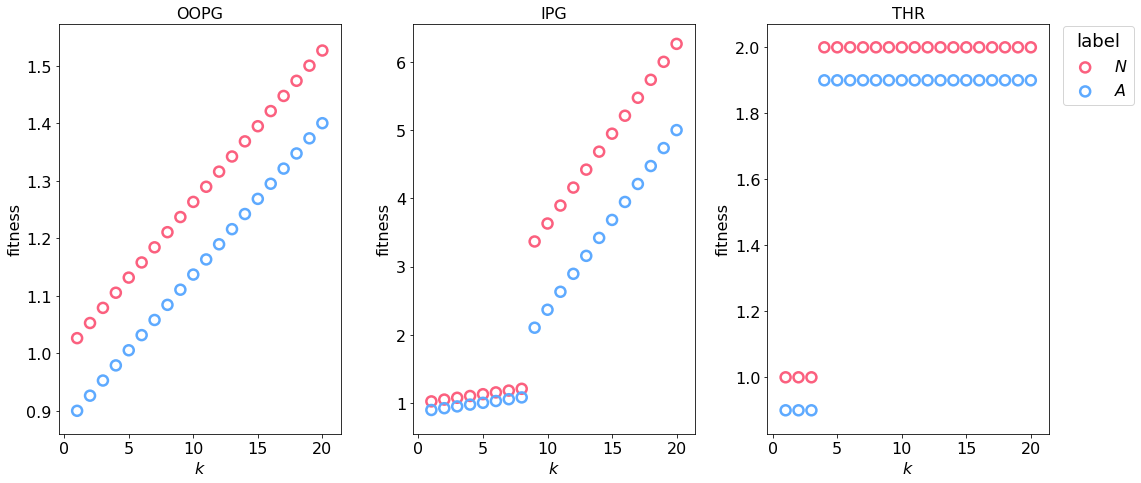

In [95]:
fig = plt.figure(figsize=(15,7))
for cont, payoff_type in enumerate(fit_df['payoff_func'].unique()):
    df_aux = fit_df[fit_df['payoff_func'] == payoff_type]
    ax = fig.add_subplot(1, 3, cont+1)
    for i, label in enumerate(fit_df['label'].unique()):
        ax.scatter(df_aux[df_aux['label']==label]['k'], df_aux[df_aux['label']==label]['fitness'], color=COLORS[i+2], facecolors='none',
                   marker='o', linewidth=2.5, s=100,
                   label=r'${}$'.format(label))
    ax.set_xlabel(r'$k$', fontsize=16)
    ax.set_ylabel(r'fitness', fontsize=16)
    ax.set_title(payoff_type.upper(), fontsize=16)
legend = plt.legend(title='label', fancybox=True, fontsize=16, facecolor='white', bbox_to_anchor=(1.02, 1.015))
legend.get_title().set_fontsize('18')
plt.tight_layout()
#plt.show()
fig.savefig(FOLDER_TO_SAVE + 'fitness_functions.pdf', bbox_inches='tight')

In [108]:
payoffs_set = {
    'oopg': lambda delta: (n, b, c, delta),
    'srpg': lambda delta: (n, b, c, delta),
    'ipg': lambda delta: (n, b, c, delta, T, theta),
    'thr': lambda delta: (n, 10, c, delta, 10, 4)
}

In [109]:
fit_df = pd.DataFrame()
avg_fitness_fun = lambda k, v_k, args: (k*fn_fun(v_k)(1, k, *args) + (args[0]-k)*fn_fun(v_k)(0, k, *args))/args[0]
for name, v_k in payoffs_func.items():
    for delta in [0.1, 0.2, 0.4]:
        args = payoffs_set[name](delta)
        n = args[0]
        data = defaultdict(list)
        data['k'] = range(1, n+1)
        data['delta'] = [delta]*n
        data['avg_fitness'] = [avg_fitness_fun(k, v_k, args) for k in range(1, n+1)]
        data['payoff_func'] = [name.upper()]*n
        fit_df = pd.concat([fit_df, pd.DataFrame(data)])

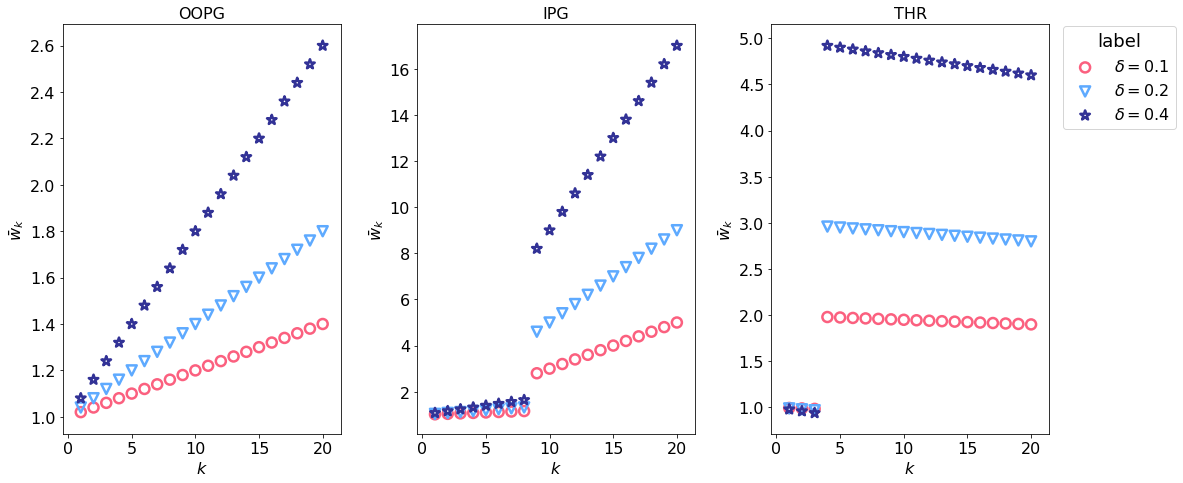

In [115]:
fig = plt.figure(figsize=(15,7))
for cont, payoff_type in enumerate(fit_df['payoff_func'].unique()):
    df_aux = fit_df[fit_df['payoff_func'] == payoff_type]
    ax = fig.add_subplot(1, 3, cont+1)
    for i, delta in enumerate(fit_df['delta'].unique()):
        ax.scatter(df_aux[df_aux['delta']==delta]['k'], df_aux[df_aux['delta']==delta]['avg_fitness'], color=COLORS[i+2], facecolors='none',
                   marker=MARKERS[i], linewidth=2.5, s=100,
                   label=r'$\delta = {}$'.format(delta))
    ax.set_xlabel(r'$k$', fontsize=16)
    ax.set_ylabel(r'$\bar{w}_k$', fontsize=16)
    ax.set_title(payoff_type.upper(), fontsize=16)
legend = plt.legend(title='label', fancybox=True, fontsize=16, facecolor='white', bbox_to_anchor=(1.02, 1.015))
legend.get_title().set_fontsize('18')
plt.tight_layout()
#plt.show()
fig.savefig(FOLDER_TO_SAVE + 'avg_fitness_functions.pdf', bbox_inches='tight')

In [116]:
MARKERS = ['o', 'v', 's', '*', '+']

In [96]:
def get_dataset_rho_m_varying_delta(payoffs_func, payoffs_set, delta_values, m_values=np.linspace(0., 1., 100)):
    df = pd.DataFrame()
    for k, v_k in payoffs_func.items():
        args = payoffs_set[k]
        data = {'m': [], 'rho': [], 'delta': []}
        for delta in delta_values:
            try:
                rho_values = [float(MatrixCalculator(v_k, m, args(delta)).calc_rho()) for m in m_values]
            except:
                import pdb; pdb.set_trace()
            data['m'] += list(m_values)
            data['rho'] += rho_values
            data['delta'] += [delta]*len(m_values)
        data['payoff_func'] = [k]*len(data['m'])
        df = pd.concat([df, pd.DataFrame(data)])
    return df


def plot_df(df, xlims=[0., 0.75], ylims=[0, 2.6], save=False):
    fig = plt.figure(figsize=(15,7))
    for cont, payoff_type in enumerate(df['payoff_func'].unique()):
        df_aux = df[df['payoff_func'] == payoff_type]
        ax = fig.add_subplot(1, 3, cont+1)
        for i, delta in enumerate(df['delta'].unique()):
            ax.plot(df_aux[df_aux['delta']==delta]['m'], df_aux[df_aux['delta']==delta]['rho'], color=COLORS[i+2], linewidth=2, marker=MARKERS[i], markevery=5,
                    label=r'$\delta={}$'.format(delta), ms=8)
        ax.hlines(1., linestyles='dashed', color='black', xmin=-0.5, xmax=1.2)
        ax.set_xlabel(r'$m$', fontsize=16)
        ax.set_ylabel(r'$\rho$', fontsize=16)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(payoff_type.upper(), fontsize=16)
    legend = plt.legend(title='label', fancybox=True, fontsize=16, facecolor='white', bbox_to_anchor=(1.52, 1.015))
    legend.get_title().set_fontsize('18')
    plt.tight_layout()
    if save:
        fig.savefig(FOLDER_TO_SAVE + 'rho_m.pdf', bbox_inches='tight')
    else:
        plt.show()

In [97]:
n = 20
T = 10
theta = 8
b = 5
b_prime = 5
c = 1

In [98]:
payoffs_set = {
    'oopg': lambda delta: (n, b, c, delta),
    'srpg': lambda delta: (n, b, c, delta),
    'ipg': lambda delta: (n, b, c, delta, T, theta),
    'thr': lambda delta: (n, 10, c, delta, 10, 4)
}

payoffs_func = {'oopg': oopg_payoff_func, 'ipg': ipg_payoff_func, 'thr': thr_payoff_func}
m_values = np.linspace(0., 1., 100)
delta_values = [.1, .2, .4]

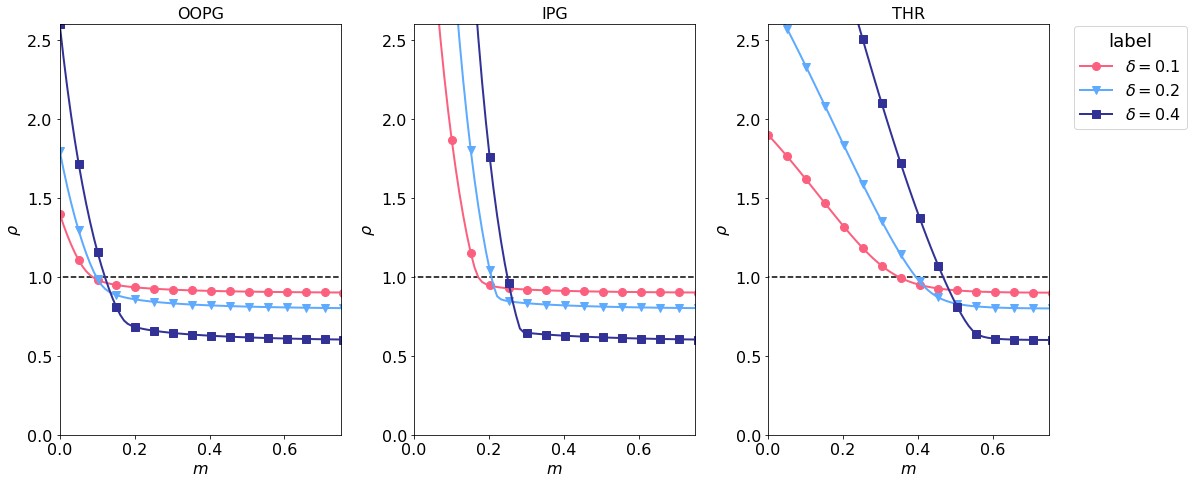

In [99]:
df = get_dataset_rho_m_varying_delta(payoffs_func, payoffs_set, delta_values, m_values=np.linspace(0., 1., 100))
plot_df(df, save=True)

In [20]:
def compare_varying_b_c(b, c):
    payoffs_set = {
        'oopg': lambda delta: (n, b, c, delta),
        'srpg': lambda delta: (n, b, c, delta),
    }
    df = get_dataset_rho_m_varying_delta({'oopg': oopg_payoff_func, 'srpg': srpg_payoff_func}, payoffs_set, delta_values, m_values=np.linspace(0., 1., 100))
    plot_df(df, xlims=[0., 1.])

b_widget = widgets.IntSlider(value=b, min=1, max=20, style={'font-size': 'large'})
c_widget = widgets.IntSlider(value=c, min=1, max=20)

In [21]:
w = interactive(compare_varying_b_c, b=b_widget, c=c_widget)
display(w)

interactive(children=(IntSlider(value=5, description='b', max=20, min=1), IntSlider(value=1, description='c', max=20, min=1), Output()), _dom_classes=('widget-interact',))

In [22]:
m = 0.1

In [23]:
df = pd.DataFrame()
for k, v_k in {'oopg': oopg_payoff_func, 'ipg': ipg_payoff_func, 'thr': thr_payoff_func}.items():
    args = payoffs_set[k]
    data = {'k': [], 'nu_k': [], 'delta': []}
    for delta in [0.01, 0.3]:
        data['nu_k'] += list(MatrixCalculator(v_k, m, args(delta)).calc_nu())
        data['k'] += list(range(1, n+1))
        data['delta'] += [delta]*n
    data['payoff_func'] = [k.upper()]*len(data['k'])
    df = pd.concat([df, pd.DataFrame(data)])

In [24]:
print('Payoffs:')
for k, args in payoffs_set.items():
    print(k.upper(), args(0.01))

Payoffs:
OOPG (20, 5, 1, 0.01)
SRPG (20, 5, 1, 0.01)
IPG (20, 5, 1, 0.01, 10, 8)
THR (20, 10, 1, 0.01, 10, 4)


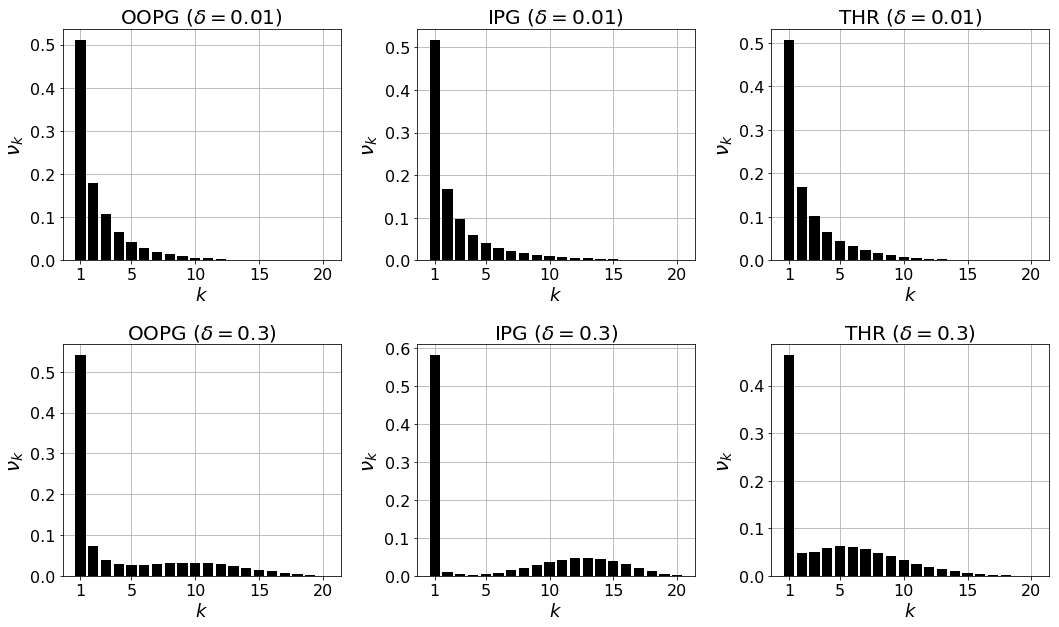

In [25]:
fig, ax = plt.subplots(2, 3, figsize=(15, 9))
for i, delta in enumerate(df['delta'].unique()):
    for j, payoff_func in enumerate(['OOPG', 'IPG', 'THR']):
        title = r'{} ($\delta = {}$)'.format(payoff_func, delta)
        df_aux = df[(df['delta']==delta)&(df['payoff_func']==payoff_func)]
        x = df_aux['k'].values
        y = df_aux['nu_k'].values
        this_ax = ax[i][j]
        this_ax.grid(True)
        this_ax.bar(x, y, color='black')
        this_ax.set_title(title, fontsize=20)
        this_ax.set_xlabel(r'$k$', fontsize=18)
        this_ax.set_ylabel(r'$\nu_k$', fontsize=20)
        this_ax.set_xticks([1,5, 10, 15, 20])
plt.tight_layout()
#plt.savefig(FOLDER_TO_SAVE + 'k_distribution_small_medium_delta.pdf')

In [26]:
t = 500
n = 2

In [27]:
payoffs_set = {
    'oopg': lambda delta: (n, b, c, delta),
    'ipg': lambda delta: (n, b, c, delta, T, theta),
    'thr': lambda delta: (n, 10, c, delta, 10, 4)
}

In [28]:
mat = MatrixCalculator(oopg_payoff_func, m, payoffs_set['oopg'](0.01))

In [29]:
initial2freqs = {}
for i in range(50):
    freqs = np.random.random(2)
    freqs[0] += 20
    freqs = freqs/np.sum(freqs)
    all_freqs = np.empty((t+1, 2))
    all_freqs[0] = freqs
    for period in range(t):
        all_freqs[period+1] = np.matmul(all_freqs[period], mat.calc_matrix_r())
    initial2freqs[tuple(freqs)] = np.array(all_freqs)  

In [30]:
nu = mat.calc_nu()

In [31]:
y = lambda x: nu[1]*x/nu[0]

In [32]:
x_values = np.linspace(0.,.5, 10)
y(x_values)

array([0.        , 0.06119831, 0.12239662, 0.18359494, 0.24479325,
       0.30599156, 0.36718987, 0.42838819, 0.4895865 , 0.55078481])

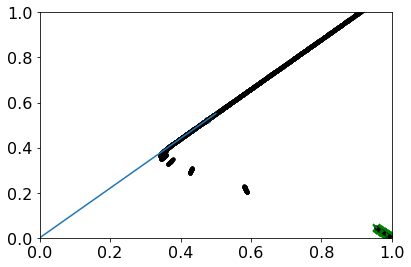

In [33]:
plt.plot(x_values, y(x_values))
plt.scatter([nu[0]], [nu[1]])
for init, all_freqs in initial2freqs.items():
    plt.scatter([init[0]], [init[1]], marker='x', s=50, color='green')
    plt.scatter(all_freqs[:,0], all_freqs[:,1], color='black', s=10)
plt.xlim([0,1])
plt.ylim([0,1])
plt.tight_layout()